# Modelo AR(p) Disney
Katlyn Goeujon-Mackness <br>
29/04/2025

## Introducción
### Objetivo
Breve descripción del objetivo del análisis.

### Modelos AR(p)
**El modelo AR(1), o modelo autoregresivo de orden 1**, se utiliza en series de tiempo para predecir el valor actual de una variable basándose en su valor inmediatamente anterior. Es el modelo autoregresivo más básico y se utiliza como base para modelos más complejos, como AR(p) de órdenes superiores.

#### Componentes
* media constante mu (𝜇)
* coeficiente phi (𝜙)
* término de error de ruido blanco

El modelo es especialmente útil para series temporales estacionarias donde 𝜙 está entre -1 y 1, con dos casos importantes:
1. 𝜙 positivo: Con "Momentum", genera una correlación positiva y un crecimiento que decae con el tiempo.
2. 𝜙 negativo: Con inversión de media, produce alternancias entre subidas y bajadas en las observaciones.

### Contexto del Conjunto de Datos
Consideraremos la información histórica diaria de precios para la empresa Walt Disney Company (cuya sigla bursátil es “DIS”) contenida en el sitio de Yahoo Finance para el periodo que va del 1 de Enero del 2023 al 31 de Marzo del 2023 usando los modelos auto-regresivos AR(p).

## Méthodo
Utilizaremos librerías estadísticas para implementar modelos AR(1) en el análisis de precios de acciones. Veremos cómo ajustar modelos a datos de entrenamiento y realizar predicciones precisas.

In [109]:
# Importar librerías
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA

In [110]:
# Solucionar un problema de yfinance
from curl_cffi import requests
session = requests.Session(impersonate="chrome")
ticker = yf.Ticker("DIS", session=session)

In [111]:
# Cargar los datos históricos desde Yahoo Finance
disney = yf.download(tickers="DIS", start='2023-01-01', end='2023-03-31', rounding=True)
disney

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,DIS,DIS,DIS,DIS,DIS
Date,,,,,
2023-01-03,87.88,88.87,86.76,87.89,14997100
2023-01-04,90.86,91.62,88.27,88.90,14957200
2023-01-05,90.80,91.35,89.41,90.54,11622600
2023-01-06,92.77,93.53,90.21,91.53,9828100
2023-01-09,93.61,94.53,92.31,93.28,11675800
...,...,...,...,...,...
2023-03-24,92.93,93.84,91.88,93.65,9534600
2023-03-27,94.45,94.85,93.23,93.62,7487900


In [112]:
# Save the Disney data to a CSV file
# disney.to_csv('disney_data.csv', index=True)

In [113]:
disney = disney['Close']
disney

Ticker,DIS
Date,
2023-01-03,87.88
2023-01-04,90.86
2023-01-05,90.80
2023-01-06,92.77
2023-01-09,93.61
...,...
2023-03-24,92.93
2023-03-27,94.45
2023-03-28,93.66


## Exploración de Datos

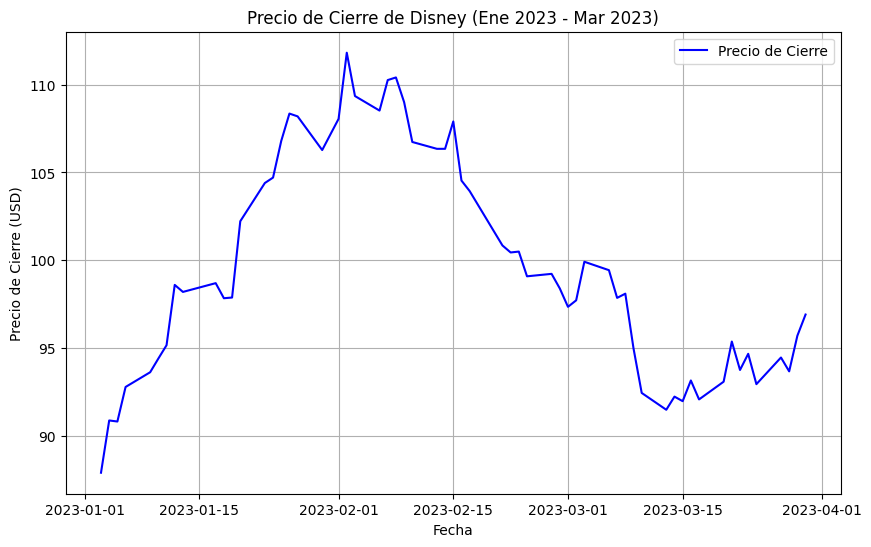

In [114]:
# Graficar los datos de cierre de Disney
plt.figure(figsize=(10, 6))
plt.plot(disney, label='Precio de Cierre', color='blue')
plt.title('Precio de Cierre de Disney (Ene 2023 - Mar 2023)')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')
plt.legend()
plt.grid()
plt.show()

  ### Selección del Modelo AR(p)

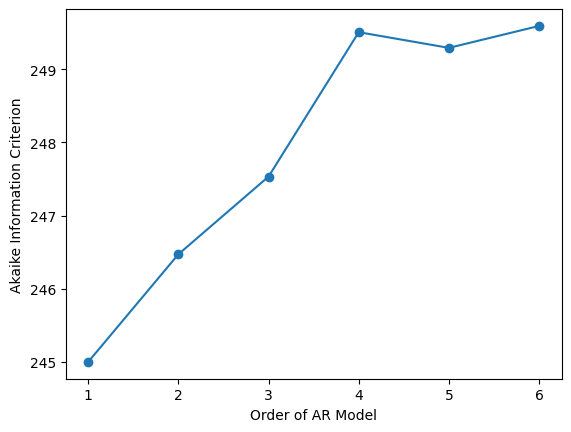

In [115]:
# Determinación del valor adadecuado de p para AR(p) apartir
#  del criterio de información Akaike

AIC = np.zeros(7)
for p in range(7):
    mod = ARIMA(disney, order=(p,0,0))
    res = mod.fit()
    AIC[p] = res.aic

# Plot the BIC as a function of p
plt.plot(range(1,7), AIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Akaike Information Criterion')
plt.show()

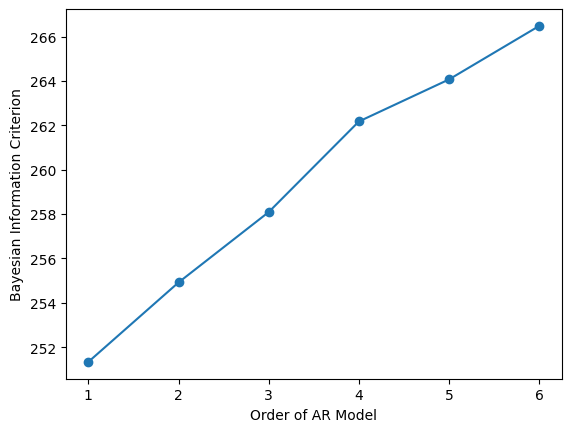

In [116]:
# Determinación del valor adadecuado de p para AR(p) apartir
#  del criterio de información Bayesiano

BIC = np.zeros(7)
for p in range(7):
    mod = ARIMA(disney, order=(p,0,0))
    res = mod.fit()
    BIC[p] = res.bic

# Plot the BIC as a function of p
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

Conclusión: Según los criterios de información Akaike y Bayesiano, el valor p óptimo es **1**.

## Modelación

### División de Datos

In [117]:
# Dividir los datos en conjuntos de entrenamiento (70%) y prueba (30%).
disney.index = pd.to_datetime(disney.index)
len_train = int(len(disney)*0.8)
len_train

48

In [118]:
len_test = int(len(disney)*0.2)
len_test

12

In [119]:
# Definición de grupos de prueba y entrenamiento
train = disney[0:len_train]

test = disney[len_train:]

[ 1.          0.88409269  0.78141411  0.68480282  0.61334895  0.52990295
  0.4452171   0.35834498  0.2820985   0.18754477  0.07604041 -0.03183198
 -0.14796236 -0.23437843 -0.31015931 -0.39229674 -0.43506145]


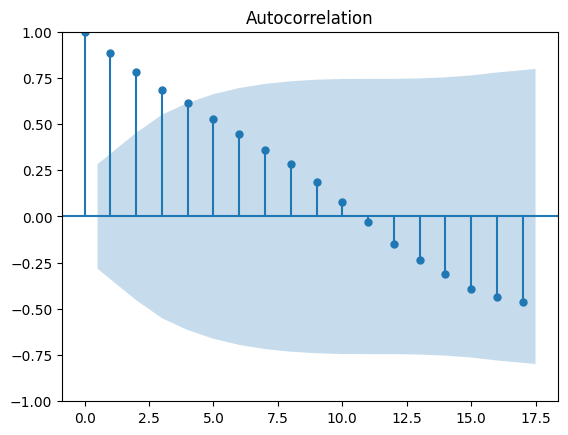

In [120]:
# Generar gráficos de autocorrelación (ACF) y autocorrelación parcial (PACF).
acf_array = acf(train)
print(acf_array)

# Gráfico con un nivel de confianza del 95%
plot_acf(train, alpha=0.05)
plt.show()


Conclusión: La disminución gradual de los puntos sugiere la presencia de una tendencia en los datos. Además, al observar que los valores cruzan la línea de cero, se puede inferir un comportamiento estacional en la serie temporal.

### Ajuste del Modelo

In [121]:
# Entrenar el modelo AR(p) seleccionado en el conjunto de entrenamiento.

# Ajusta un modelo AR(1) con herramientas de Python, prediciendo los valores futuros
mod = ARIMA(train, order=(1,0,0))
res = mod.fit()

# Evaluar el ajuste del modelo.
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                    DIS   No. Observations:                   48
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -96.554
Date:                Sat, 03 May 2025   AIC                            199.107
Time:                        00:57:31   BIC                            204.721
Sample:                             0   HQIC                           201.229
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         94.1984      8.815     10.686      0.000      76.921     111.476
ar.L1          0.9736      0.034     28.682      0.000       0.907       1.040
sigma2         3.0760      0.655      4.697      0.0

Conclusión: Este modelo captura una relación autorregresiva, que indica que los valores pasados influyen mucho los del futuro.

## Validación del Modelo
Compararemos el grupo de prueba para validar y evaluar el modelo.

In [122]:
# Generar lista de predicciones puntuales 
predicciones = res.forecast(len(test))

In [123]:
# Calcular intervalos de confianza del 90% para las predicciones.
# Calcula los intervales de confianza
conf_test = res.get_forecast(len(test)).conf_int(alpha=0.05)

In [124]:
conf_test2 = conf_test.reset_index()
conf_test2.reset_index(drop=True, inplace=True)
conf_test2.drop(columns=['index'], inplace=True)
conf_test2

,lower DIS,upper DIS
0,88.104495,94.979442
1,86.814404,96.409675
2,85.880669,97.479854
3,85.136050,98.357318
4,84.514663,99.108046
5,83.982157,99.766482
6,83.517792,100.353455
7,83.107835,100.882786
8,82.742598,101.364248
9,82.414920,101.805085


In [ ]:
# Convertir las predicciones en un DataFrame
predicciones_df = pd.DataFrame(predicciones)
predicciones_df = predicciones.reset_index()
predicciones_df

,index,predicted_mean
0,48,91.541969
1,49,91.612039
2,50,91.680261
3,51,91.746684
4,52,91.811355
5,53,91.874320
6,54,91.935623
7,55,91.995310
8,56,92.053423
9,57,92.110003


In [126]:
predicciones_df.reset_index(drop=True, inplace=True)
predicciones_df

# Reset the index and drop the 'index' column from predicciones_df
predicciones_df.reset_index(drop=True, inplace=True)
predicciones_df.drop(columns=['index'], inplace=True)
predicciones_df

,predicted_mean
0,91.541969
1,91.612039
2,91.680261
3,91.746684
4,91.811355
5,91.874320
6,91.935623
7,91.995310
8,92.053423
9,92.110003


In [127]:
# Copiar el DataFrame de test
test2 = test.reset_index()
test2.index.name = None

In [128]:
# Conjuntar predicciones_df y test2
test3 = test2.join(predicciones_df, how='inner')

In [129]:
# Conjuntar test3 con sus intervalos de confianza
test4 = test3.join(conf_test2, how='inner')

In [142]:
test4

,Date,DIS,predicted_mean,lower DIS,upper DIS
0,2023-03-14,92.22,91.541969,88.104495,94.979442
1,2023-03-15,91.96,91.612039,86.814404,96.409675
2,2023-03-16,93.14,91.680261,85.880669,97.479854
3,2023-03-17,92.06,91.746684,85.136050,98.357318
4,2023-03-20,93.07,91.811355,84.514663,99.108046
5,2023-03-21,95.36,91.874320,83.982157,99.766482
6,2023-03-22,93.74,91.935623,83.517792,100.353455
7,2023-03-23,94.66,91.995310,83.107835,100.882786
8,2023-03-24,92.93,92.053423,82.742598,101.364248
9,2023-03-27,94.45,92.110003,82.414920,101.805085


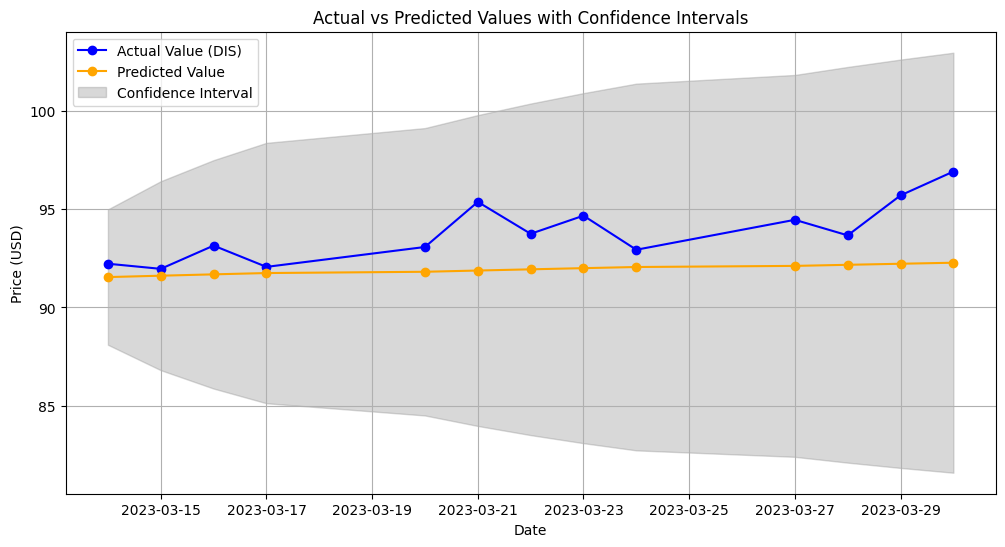

In [130]:
# Visualize the data
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(test4['Date'], test4['DIS'], label='Actual Value (DIS)', color='blue', marker='o')

# Plot predicted values
plt.plot(test4['Date'], test4['predicted_mean'], label='Predicted Value', color='orange', marker='o')

# Plot confidence intervals
plt.fill_between(test4['Date'], test4['lower DIS'], test4['upper DIS'], color='gray', alpha=0.3, label='Confidence Interval')

# Add labels, title, and legend
plt.title('Actual vs Predicted Values with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

## Evaluación del Modelo
Evaluaremos la precisión de los modelos AR(1) mediante métricas como el MSE y MAPE. 

In [131]:
acumulador1  = 0
acumulador2  = 0

for contador in range(len(test)):
    acumulador1 = acumulador1 + (test.iloc[contador]['DIS'] - predicciones.iloc[contador]) ** 2
    acumulador2 = acumulador2 + np.abs((test.iloc[contador]['DIS'] - predicciones.iloc[contador]) / 
                                       test.iloc[contador]['DIS'])
    
mse = acumulador1 / 101
rmse = np.round(np.sqrt(mse),2)
mape = np.round((acumulador2 / 101) * 100,2)

print("RMSE:", rmse, "\nMAPE:", mape, "%")

RMSE: 0.83 
MAPE: 0.26 %


Conclusión: En promedio, el modelo tiene un error bajo, lo que sugiere más precisión. Además, el MAPE bajo de 5% sugiere un modelo muy preciso. Esto indica que el model está capturando bein los patrones de la serie temporal analizada.

## Implementación/Pronóstico

In [132]:
# Pronóstico de los siguientes 5 períodos posteriores al último dato histórico
pred_extended = res.forecast(len(test) + 20)


In [133]:
# Preparar DataFrames para pronosticar
train = pd.DataFrame(train)

# Copiar las fechas del DataFrame de prueba
lista = test4['Date']
lista = pd.DataFrame(lista)


In [134]:
# Genera fechas de predicciones para los siguientes 30 días laborales
k = 20
lista2 = []
for day in range(1,21):
    fecha = ((pd.to_datetime("2023-03-31") + pd.offsets.BDay(day)).date())
    lista2.append(fecha)
lista2 = pd.DataFrame(lista2, columns=['Date'])
lista2['Date'] = pd.to_datetime(lista2['Date'])


In [135]:
# Conjuntar las dos listas de fechas
fechas = pd.concat([lista, lista2], ignore_index=True)
fechas = fechas.reset_index(drop=True)


In [136]:
# Convertir las predicciones en un DataFrame
pred_extended_df = pd.DataFrame(pred_extended)
pred_extended_df.reset_index(drop=True, inplace=True)

In [137]:
# Conjuntar las fechas y predicciones
frames = [fechas, pred_extended_df]
result = pd.concat(frames, axis=1, join = 'inner')
result.columns = ['Date', 'Predicciones']

In [138]:
# Calcular intervalos de confianza para las predicciones 
conf_pred = res.get_forecast(len(test) + 30).conf_int(alpha=0.05)

# Copiar intervalos de confianza y reiniciar el índice
conf_pred2 = conf_pred.reset_index()
conf_pred2.drop(columns=['index'], inplace=True)

In [139]:
# Combinar fechas y intervalos de confianza 
frames = [fechas, conf_pred2]
intervalos = pd.concat(frames, axis=1, join = 'inner')

In [140]:
# Combinar predicciones y intervalos de confianza
frames = [result, conf_pred2]
result2 = pd.concat(frames, axis=1, join = 'inner')
result2

,Date,Predicciones,lower DIS,upper DIS
0,2023-03-14,91.541969,88.104495,94.979442
1,2023-03-15,91.612039,86.814404,96.409675
2,2023-03-16,91.680261,85.880669,97.479854
3,2023-03-17,91.746684,85.136050,98.357318
4,2023-03-20,91.811355,84.514663,99.108046
5,2023-03-21,91.874320,83.982157,99.766482
6,2023-03-22,91.935623,83.517792,100.353455
7,2023-03-23,91.995310,83.107835,100.882786
8,2023-03-24,92.053423,82.742598,101.364248
9,2023-03-27,92.110003,82.414920,101.805085


## Visualización de Resultados

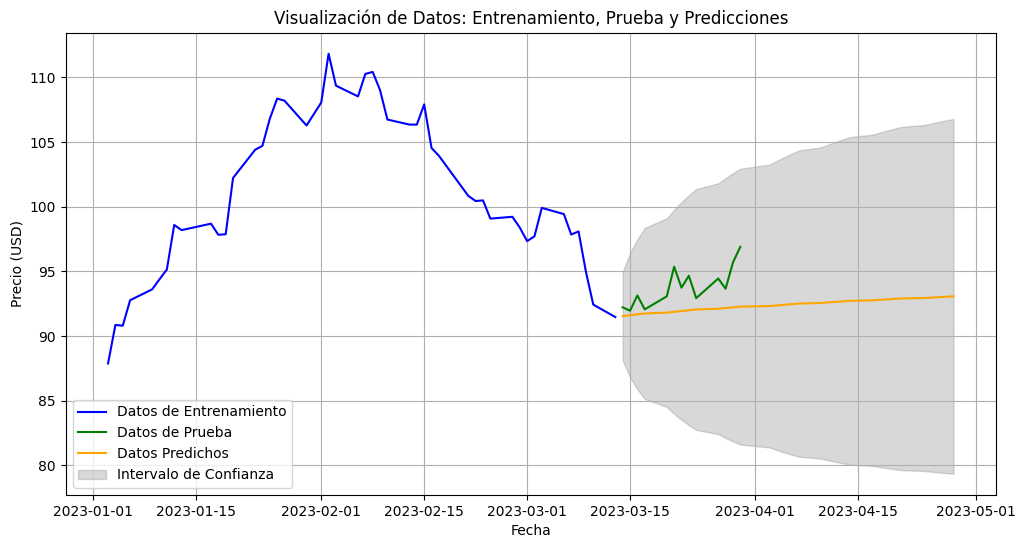

In [141]:
# Visualizar todos los datos
plt.figure(figsize=(12, 6))

# Graficar datos de entrenamiento
plt.plot(train.index, train['DIS'], label='Datos de Entrenamiento', color='blue')

# Graficar datos de prueba
plt.plot(test.index, test['DIS'], label='Datos de Prueba', color='green')

# Graficar datos predichos
plt.plot(result2['Date'], result2['Predicciones'], label='Datos Predichos', color='orange')

# Graficar intervalos de confianza
plt.fill_between(result2['Date'], result2['lower DIS'], result2['upper DIS'], 
                 color='gray', alpha=0.3, label='Intervalo de Confianza')

# Añadir etiquetas, título y leyenda
plt.title('Visualización de Datos: Entrenamiento, Prueba y Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid()
plt.show()

## Conclusiones

#### Precisión del Modelo
Según las métricas calculadas como el RMSE y el MAPE, el modelo AR(1) parece capturar bien los patrones de la serie temporal.

#### Predicciones
Las predicciones generadas se ajustan razonablemente bien a los datos de prueba. Sin embargo, los intervalos de confianza son amplios, lo que es esperado dada la incertidumbre asociada con los valores futures.

#### Recomendaciones
Para construir un modelo más adecuado, se podrían explorar modelos más avanzados que pueden capturar patrones complejos. Además, incorporar variables externas podría mejorar las predicciones posteriores.